In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data.metrics import get_metrics

In [2]:
df = pd.read_json("../reports/ablation_all.jsonl", lines=True, orient="records")
df_all = pd.read_json("../reports/all_models.jsonl", lines=True, orient="records")
df_missing = df_all[
    (df_all["loc_levels"] == 4) & df_all["model_cls"].isin(["BiTULER", "TULHOR"])
]
df = pd.concat([df, df_missing])
df["loc_level"] = df["loc_level"].fillna("all")
metrics = ["top_5_accuracy", "top_1_accuracy", 'macro_f1']
get_metrics(df, metrics)

In [3]:
dfm = (
    df.groupby(["loc_level", "embedding_weight_factor", "embedding_type", "model_cls"])[metrics]
    .agg(["mean", "std"])
    .reset_index()
)
dfm[(dfm["model_cls"] == "BiTULER")][
    ["loc_level", "embedding_weight_factor", "embedding_type"] + metrics
].sort_values(("top_5_accuracy", "mean"), ascending=False)

loc_level embedding_weight_factor          embedding_type top_5_accuracy  \
                                                                       mean   
8        all                       1  lookup_weighted_concat       0.784354   
4       -2.0                       2  lookup_weighted_concat       0.783347   
12       all                       2  lookup_weighted_concat       0.783321   
0       -4.0                       2  lookup_weighted_concat       0.780213   
10       all                       2           lookup_concat       0.779789   
2       -3.0                       2  lookup_weighted_concat       0.768849   
6       -1.0                       2  lookup_weighted_concat       0.760068   

             top_1_accuracy            macro_f1            
         std           mean       std      mean       std  
8   0.044767       0.599511  0.099624  0.552087  0.142365  
4   0.044411       0.607643  0.105379  0.561084  0.148629  
12  0.043933       0.607612  0.104217  0.561452  0.146623  
0   0.044635       0.605624  0.105217  0.560505  0.146291  
10  0.044767       0.602824  0.103030  0.556362  0.144718  
2   0.044500       0.588764  0.129817  0.546110  0.167866  
6   0.047715       0.549310  0.108050  0.498903  0.153071

In [4]:
configs = [
    {
        "loc_level": "all",
        "embedding_weight_factor": 1,
        "embedding_type": "lookup_weighted_concat",
        'label': "-VD"
    }
]
configs += [
    {
        "loc_level": "all",
        "embedding_weight_factor": 2,
        "embedding_type": "lookup_concat",
        'label': "-WL"
    }
]
configs += [
    {
        "loc_level": -level,
        "embedding_weight_factor": 2,
        "embedding_type": "lookup_weighted_concat",
        'label': f"-L{level}"
    }
    for level in range(4, 1, -1)
]
configs += [

    {
        "loc_level": "all",
        "embedding_weight_factor": 2,
        "embedding_type": "lookup_weighted_concat",
        'label': "MiLES"
    }
]
configs[-1]['label'] = "MiLES"

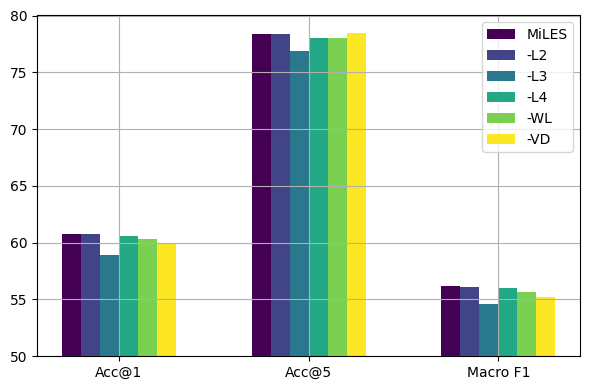

In [10]:
params = [
    "loc_level",
    "embedding_weight_factor",
    "embedding_type",
    "model_cls",
]
metrics = ["top_1_accuracy", 'top_5_accuracy', 'macro_f1']
metric_names = ['Acc@1', 'Acc@5', 'Macro F1']
dfm = df
dfm = dfm.groupby(params)[metrics].agg(["mean"]).reset_index()
dfm = dfm[dfm["model_cls"] == "BiTULER"]
dfm[metrics] *= 100

# Create bar plot data
bar_width = 0.1
x = np.arange(len(metrics))

cmap = plt.get_cmap("viridis", len(configs))
colors = cmap(range(len(configs)))

fig, ax = plt.subplots(figsize=(6, 4))

for i, config in enumerate(configs[::-1]):
    subset = dfm[
        (dfm["loc_level"] == config["loc_level"])
        & (dfm["embedding_weight_factor"] == config["embedding_weight_factor"])
        & (dfm["embedding_type"] == config["embedding_type"])
    ]
    means = subset[metrics].values[0]
    # Plot bars with error bars
    ax.bar(
        x + i * bar_width,
        means,
        bar_width,
        color=colors[i],
        # yerr=stds,
        label=config["label"],
        capsize=5,
    )

# Customize the plot
pad = 0.1
ax.set_ylim([50, 80])
ax.set_xticks(x + (bar_width * (len(configs) - 1) / 2))
ax.set_xticklabels(metric_names)
ax.grid()
ax.legend()

plt.tight_layout()

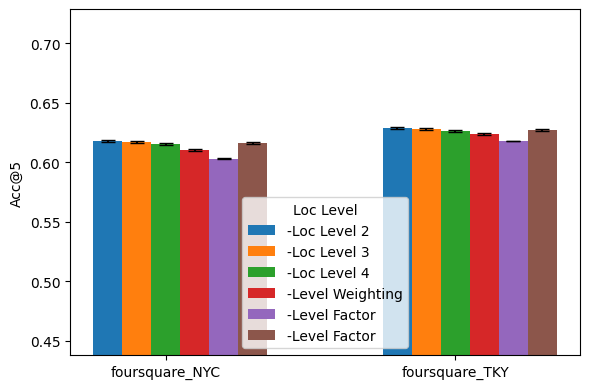

In [ ]:
params = [
    "loc_level",
    "embedding_weight_factor",
    "embedding_type",
    "dataset",
    "model_cls",
]
metric = "top_1_accuracy"
dfp = df[(df["model_cls"] == "BiTULER") & (df['dataset'].isin(['foursquare_TKY', 'foursquare_NYC']))]
dfm = dfp.groupby(params)[metrics].agg(["mean", "std"]).reset_index()

datasets = dfm["dataset"].unique()


loc_levels = dfm["loc_level"].unique()

# Create bar plot data
bar_width = 0.1
x = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(6, 4))

for i, config in enumerate(configs):
    subset = dfm[
        (dfm["loc_level"] == config["loc_level"])
        & (dfm["embedding_weight_factor"] == config["embedding_weight_factor"])
        & (dfm["embedding_type"] == config["embedding_type"])
    ]
    means = subset[metric]["mean"]
    stds = subset[metric]["std"]

    # Plot bars with error bars
    ax.bar(
        x + i * bar_width,
        means,
        bar_width,
        # yerr=stds,
        label=config['label'],
        capsize=5,
    )

# Customize the plot
pad = 0.1
ax.set_ylim([dfm[metric]["mean"].min() - pad, dfm[metric]["mean"].max() + pad])
ax.set_ylabel("Acc@5")
ax.set_xticks(x + (bar_width * (len(loc_levels) - 1) / 2))
ax.set_xticklabels(datasets)
ax.legend(title="Loc Level")

plt.tight_layout()